In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import split_dataset, create_sequences, root_mean_squared_error, plot_metrics

daily = pd.read_csv('../../../Dataset/Boulder_Daily.csv')
daily.drop(columns={'Unnamed: 0'}, inplace=True)
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1668 entries, 0 to 1667
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Energy__kWh_   1668 non-null   float64
 1   Weekday        1668 non-null   object 
 2   Month          1668 non-null   object 
 3   Minimum T      1668 non-null   int64  
 4   Maximum T      1668 non-null   int64  
 5   Snow           1668 non-null   float64
 6   Precipitation  1668 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 91.3+ KB


    Scale the Dataset with MinMaxScaler / One-Hot Encode and Extract the Entire Scaled Dataset

In [19]:
# Define the columns we need to scale and we need to use for One-Hot Encoding
columns_to_scale = ['Energy__kWh_', 'Minimum T', 'Maximum T', 'Snow', 'Precipitation']
categorical_columns = ['Weekday','Month']

# MinMax scaling for numerical columns and One-hot encoding for categorical columns
scaler = MinMaxScaler()
daily_scaled = daily.copy()
daily_scaled[columns_to_scale] = scaler.fit_transform(daily[columns_to_scale])

# One-hot encoding for categorical columns
onehot_encoder = OneHotEncoder(sparse=False)
categorical_encoded = onehot_encoder.fit_transform(daily[categorical_columns])

# Get the feature names from the encoder
encoded_columns = []
for col, values in zip(categorical_columns, onehot_encoder.categories_):
    encoded_columns.extend([f'{col}_{value}' for value in values])

# Create DataFrame with encoded columns
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoded_columns)

# Concatenate the new encoded columns to the original DataFrame
daily_scaled = pd.concat([daily_scaled, categorical_encoded_df], axis=1)

# Drop the original categorical columns
daily_scaled = daily_scaled.drop(categorical_columns, axis=1)
daily_scaled.columns

Index(['Energy__kWh_', 'Minimum T', 'Maximum T', 'Snow', 'Precipitation',
       'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday',
       'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
       'Weekday_Wednesday', 'Month_April', 'Month_August', 'Month_December',
       'Month_February', 'Month_January', 'Month_July', 'Month_June',
       'Month_March', 'Month_May', 'Month_November', 'Month_October',
       'Month_September'],
      dtype='object')

    Divided the dataset into training, testing, and validation datasets according to 0.70, 0.20, and 0.10, respectively.

In [20]:
train_daily_scaled, val_daily_scaled, test_daily_scaled = split_dataset(daily_scaled, train_ratio=0.7, val_ratio=0.2)

Training split ratio:   0.7
Validation split ratio: 0.2
Testing split ratio:    0.101

Shapes of the datasets:
(1167, 24) (333, 24) (168, 24)


    Create sequences for the Transformer model

In [21]:
sequence_length = 120
num_features = len(daily_scaled.columns)

# Create the training, validation, and test data sequences
train_data_inputs, train_data_targets = create_sequences(train_daily_scaled, sequence_length)
val_data_inputs, val_data_targets = create_sequences(val_daily_scaled, sequence_length)
test_data_inputs, test_data_targets = create_sequences(test_daily_scaled, sequence_length)

Dataset split into sequences:
Sequences shape: (1047, 120, 24)
Targets shape: (1047,)

Dataset split into sequences:
Sequences shape: (213, 120, 24)
Targets shape: (213,)

Dataset split into sequences:
Sequences shape: (48, 120, 24)
Targets shape: (48,)



    Create the Transformer Model

In [22]:
%run "../Time2Vec/Time2Vec_Transformer.ipynb"

In [23]:
num_features = len(daily_scaled.columns)
n_heads = 1
ff_dim = 64
num_layers = 6
d_k = 256 # dimensions of keys
d_v = 256 # dimensions of values

model = Time2VecTranformer(d_k, d_v, n_heads, ff_dim, num_layers, sequence_length, num_features)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 24)]    0           []                               
                                                                                                  
 time2_vector_1 (Time2Vector)   (None, 120, 2)       480         ['input_2[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 120, 26)      0           ['input_2[0][0]',                
                                                                  'time2_vector_1[0][0]']         
                                                                                                  
 transformer_encoder_6 (Transfo  (None, 120, 26)     30940       ['concatenate_1[0][0]',    

    Compile the Model

In [24]:
# Define the learning rate for Adam optimizer
learning_rate = 0.001

# Compile the manual model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse',  metrics=['mae', 'mse', root_mean_squared_error])

    Train the Model

In [25]:
# Define the parameters for training
epochs = 60
batch_size = 32

# Train the model
history = model.fit(
    train_data_inputs, train_data_targets,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_data_inputs, val_data_targets)
)

Epoch 1/60
33/33 [==============================] - 83s 1s/step - loss: 0.0364 - mae: 0.1525 - mse: 0.0364 - root_mean_squared_error: 0.1827 - val_loss: 0.0549 - val_mae: 0.2096 - val_mse: 0.0549 - val_root_mean_squared_error: 0.2354
Epoch 2/60
33/33 [==============================] - 40s 1s/step - loss: 0.0133 - mae: 0.0922 - mse: 0.0133 - root_mean_squared_error: 0.1142 - val_loss: 0.0269 - val_mae: 0.1348 - val_mse: 0.0269 - val_root_mean_squared_error: 0.1647
Epoch 3/60
33/33 [==============================] - 40s 1s/step - loss: 0.0101 - mae: 0.0796 - mse: 0.0101 - root_mean_squared_error: 0.1002 - val_loss: 0.0240 - val_mae: 0.1259 - val_mse: 0.0240 - val_root_mean_squared_error: 0.1557
Epoch 4/60
33/33 [==============================] - 40s 1s/step - loss: 0.0088 - mae: 0.0732 - mse: 0.0088 - root_mean_squared_error: 0.0929 - val_loss: 0.0224 - val_mae: 0.1205 - val_mse: 0.0224 - val_root_mean_squared_error: 0.1501
Epoch 5/60
33/33 [==============================] - 40s 1s/step 

    Evaluate the Models


In [26]:
train_eval = model.evaluate(train_data_inputs, train_data_targets, verbose=0)
val_eval = model.evaluate(val_data_inputs, val_data_targets, verbose=0)
test_eval = model.evaluate(test_data_inputs, test_data_targets, verbose=0)

print('\nEvaluation metrics:\n-------------------')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}\n'.format(train_eval[0], train_eval[3], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}\n'.format(val_eval[0], val_eval[3], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}'.format(test_eval[0], test_eval[3], test_eval[1], test_eval[2]))


Evaluation metrics:
-------------------
Training Data - Loss: 0.0049, MAE: 0.0679, RMSE: 0.0545, MSE: 0.0049

Validation Data - Loss: 0.0191, MAE: 0.1361, RMSE: 0.1054, MSE: 0.0191

Test Data - Loss: 0.1125, MAE: 0.3369, RMSE: 0.3014, MSE: 0.1125


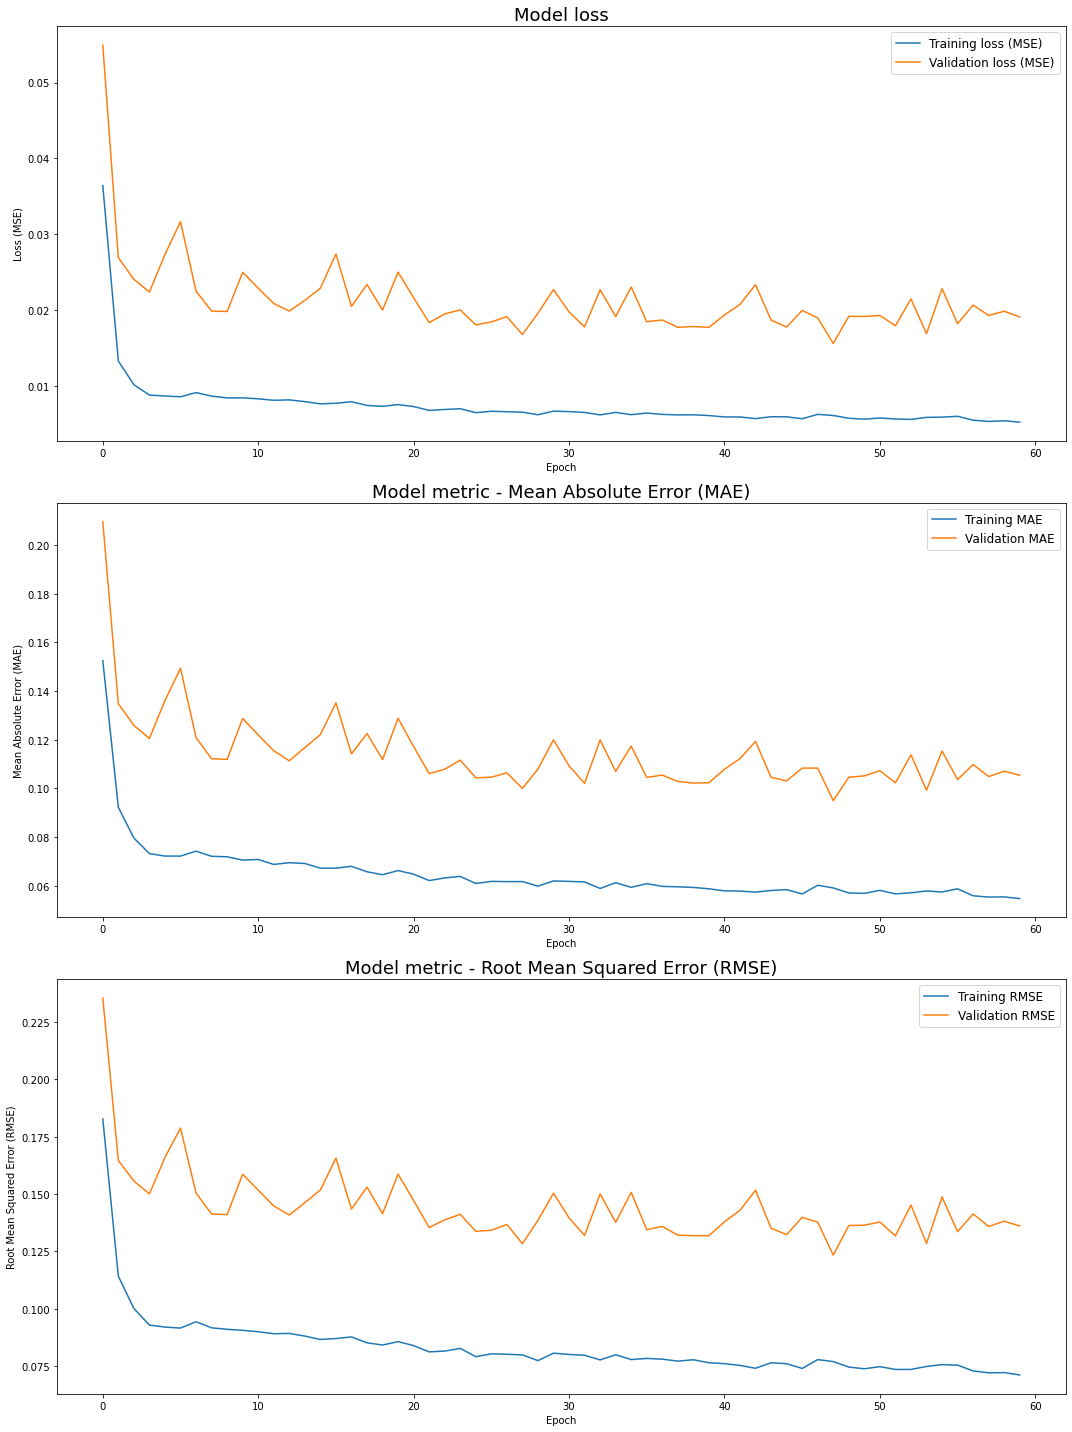

In [27]:
plot_metrics(history)